# ROIs

In [1]:
import pandas as pd
import numpy as np

from nilearn import plotting
import nilearn as nil
from nilearn.masking import apply_mask, unmask

from os import makedirs
from os.path import dirname, basename, exists, isdir
import glob as glob

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load the left and right insula masks
left_mask = nil.image.load_img('left_insula_11ROIs.nii.gz')
right_mask = nil.image.load_img('right_insula_10ROIs.nii.gz')
# Index values in the mask
print('Right insula ROI indices: ', np.unique(right_mask.get_data())[1:])
print('Left insula ROI indices: ', np.unique(left_mask.get_data())[1:])

Right insula ROI indices:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Left insula ROI indices:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]



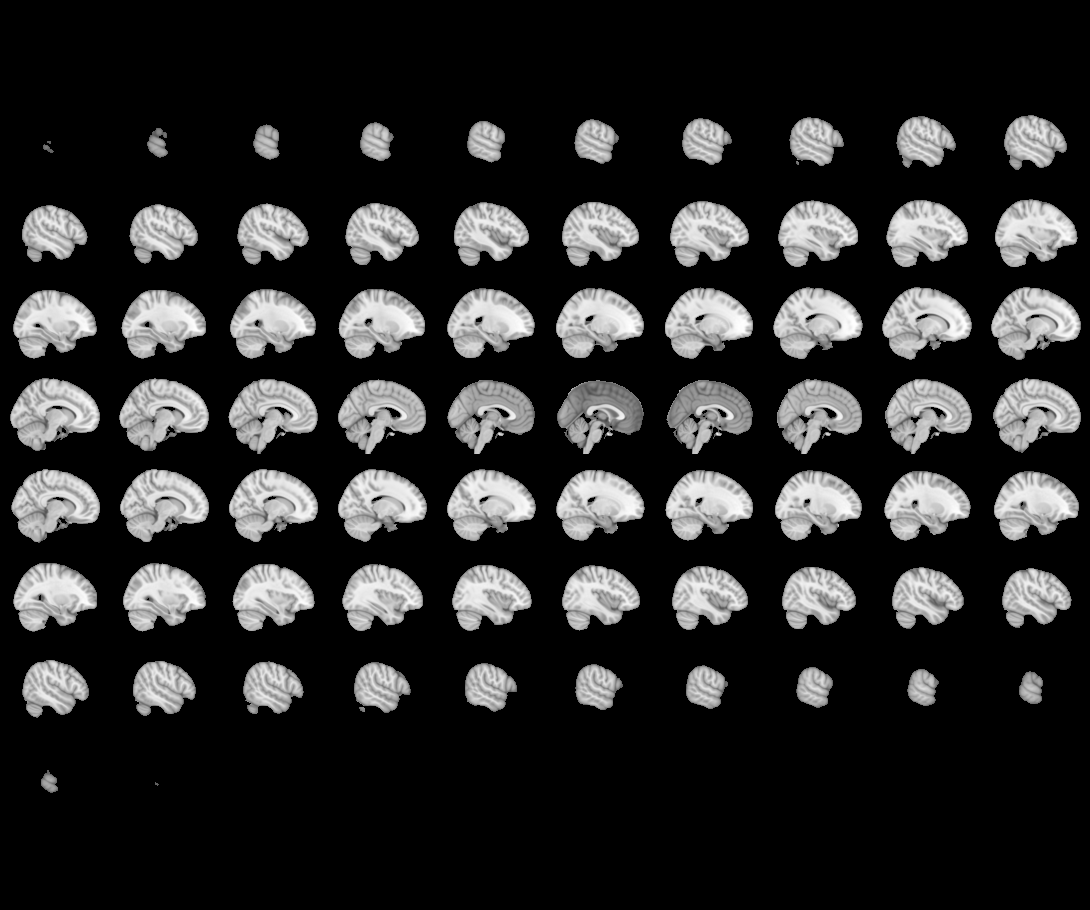
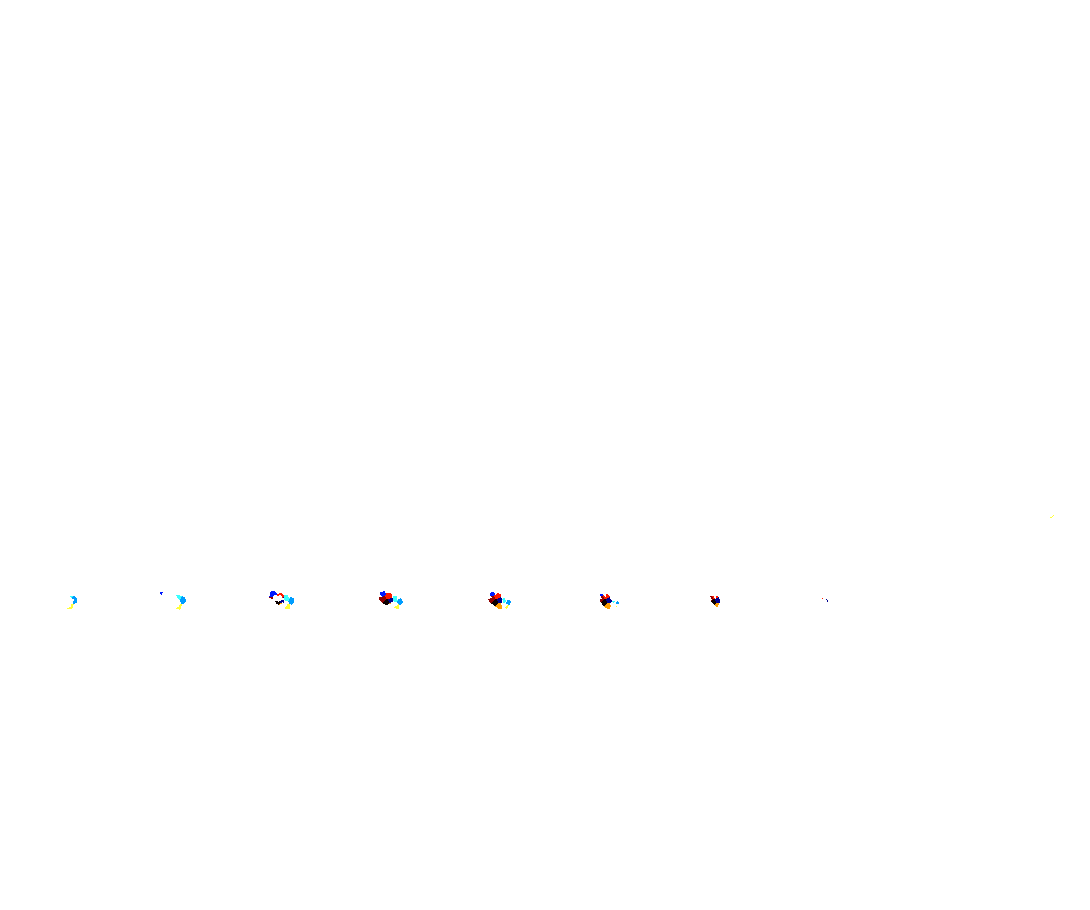

In [3]:
plotting.view_img(right_mask,dim=0,vmax=10,draw_cross=False,title='Right Insula',symmetric_cmap=False)


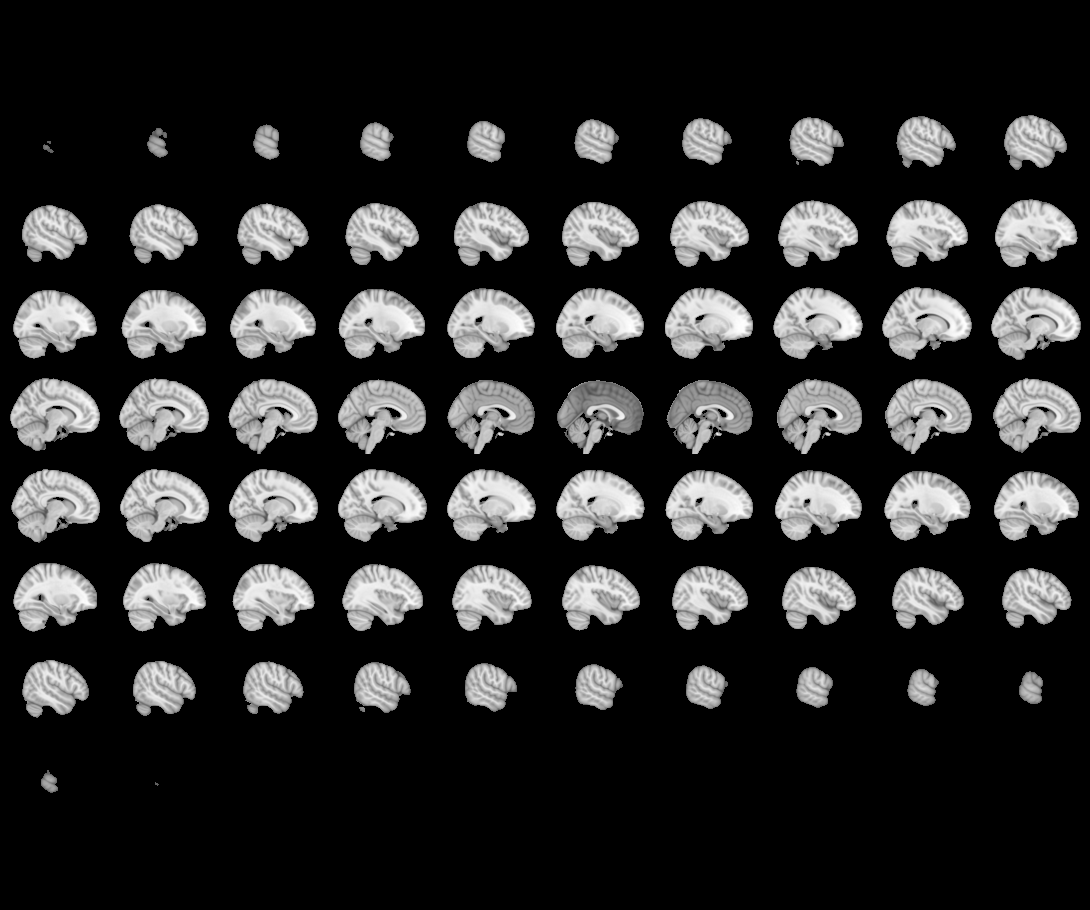
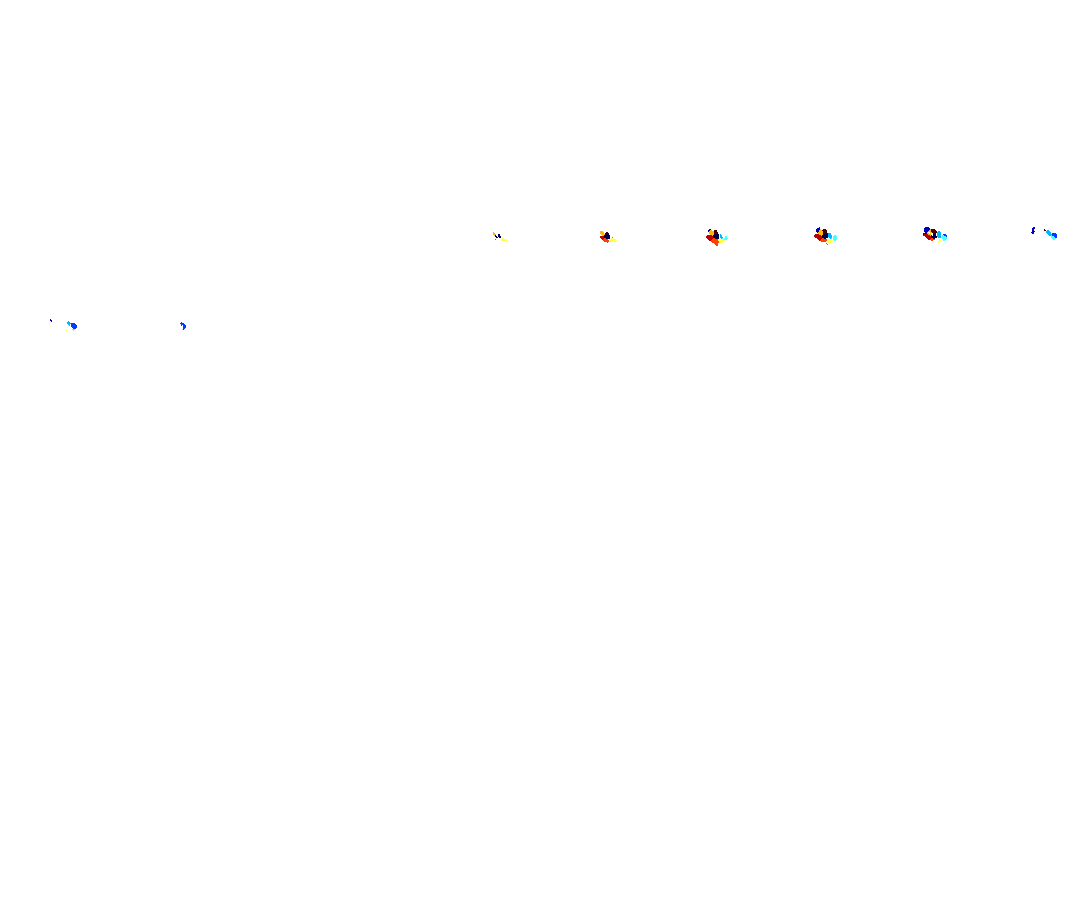

In [4]:
plotting.view_img(left_mask,dim=0,vmax=11,draw_cross=False,title='Left Insula',symmetric_cmap=False)

In [17]:
filepath = "data/threat_v_safe_insula_min_shifted.txt"
if exists(filepath):
    offset_df = pd.read_csv(filepath)
else:
    df = pd.read_csv('data/threat_v_safe_insula.txt')
    offset_df = df.copy()
    offset_df['beta'] = offset_df['beta'] - offset_df['beta'].min()
    offset_df.to_csv(filepath,sep=',',index=False,float_format='%0.4f')

In [19]:
from scipy.stats import sem
from scipy.stats import t as tdist
N = len(df['Subj'].unique())
critT = tdist(df=N-1).ppf(0.975)

In [23]:
def get_mean_df(df):
    '''
    Takes estimated response dataframe and outputs an aggregated 
    dataframe with mean response across subjects along with error bounds.
    '''
    mean_df = df.groupby(['Type','HEM','ROI','VOX','Time'])['beta'].agg([np.mean,sem]).reset_index()
    mean_df['lower_bound'] = mean_df['mean'] - critT*mean_df['sem']
    mean_df['upper_bound'] = mean_df['mean'] + critT*mean_df['sem']
    return mean_df

In [24]:
orig_mean_df = get_mean_df(df)
offset_mean_df = get_mean_df(offset_df)

In [26]:
orig_mean_df.head()

,Type,HEM,ROI,VOX,Time,mean,sem,lower_bound,upper_bound
0,safe,left,left_roi01,left_roi01_000,0.00,-0.021368,0.030901,-0.082618,0.039883
1,safe,left,left_roi01,left_roi01_000,1.25,-0.055665,0.027328,-0.109834,-0.001497
2,safe,left,left_roi01,left_roi01_000,2.50,0.055255,0.025439,0.004831,0.105679
3,safe,left,left_roi01,left_roi01_000,3.75,0.094137,0.026667,0.041277,0.146996
4,safe,left,left_roi01,left_roi01_000,5.00,0.088163,0.029145,0.030393,0.145933


# Estimated Responses

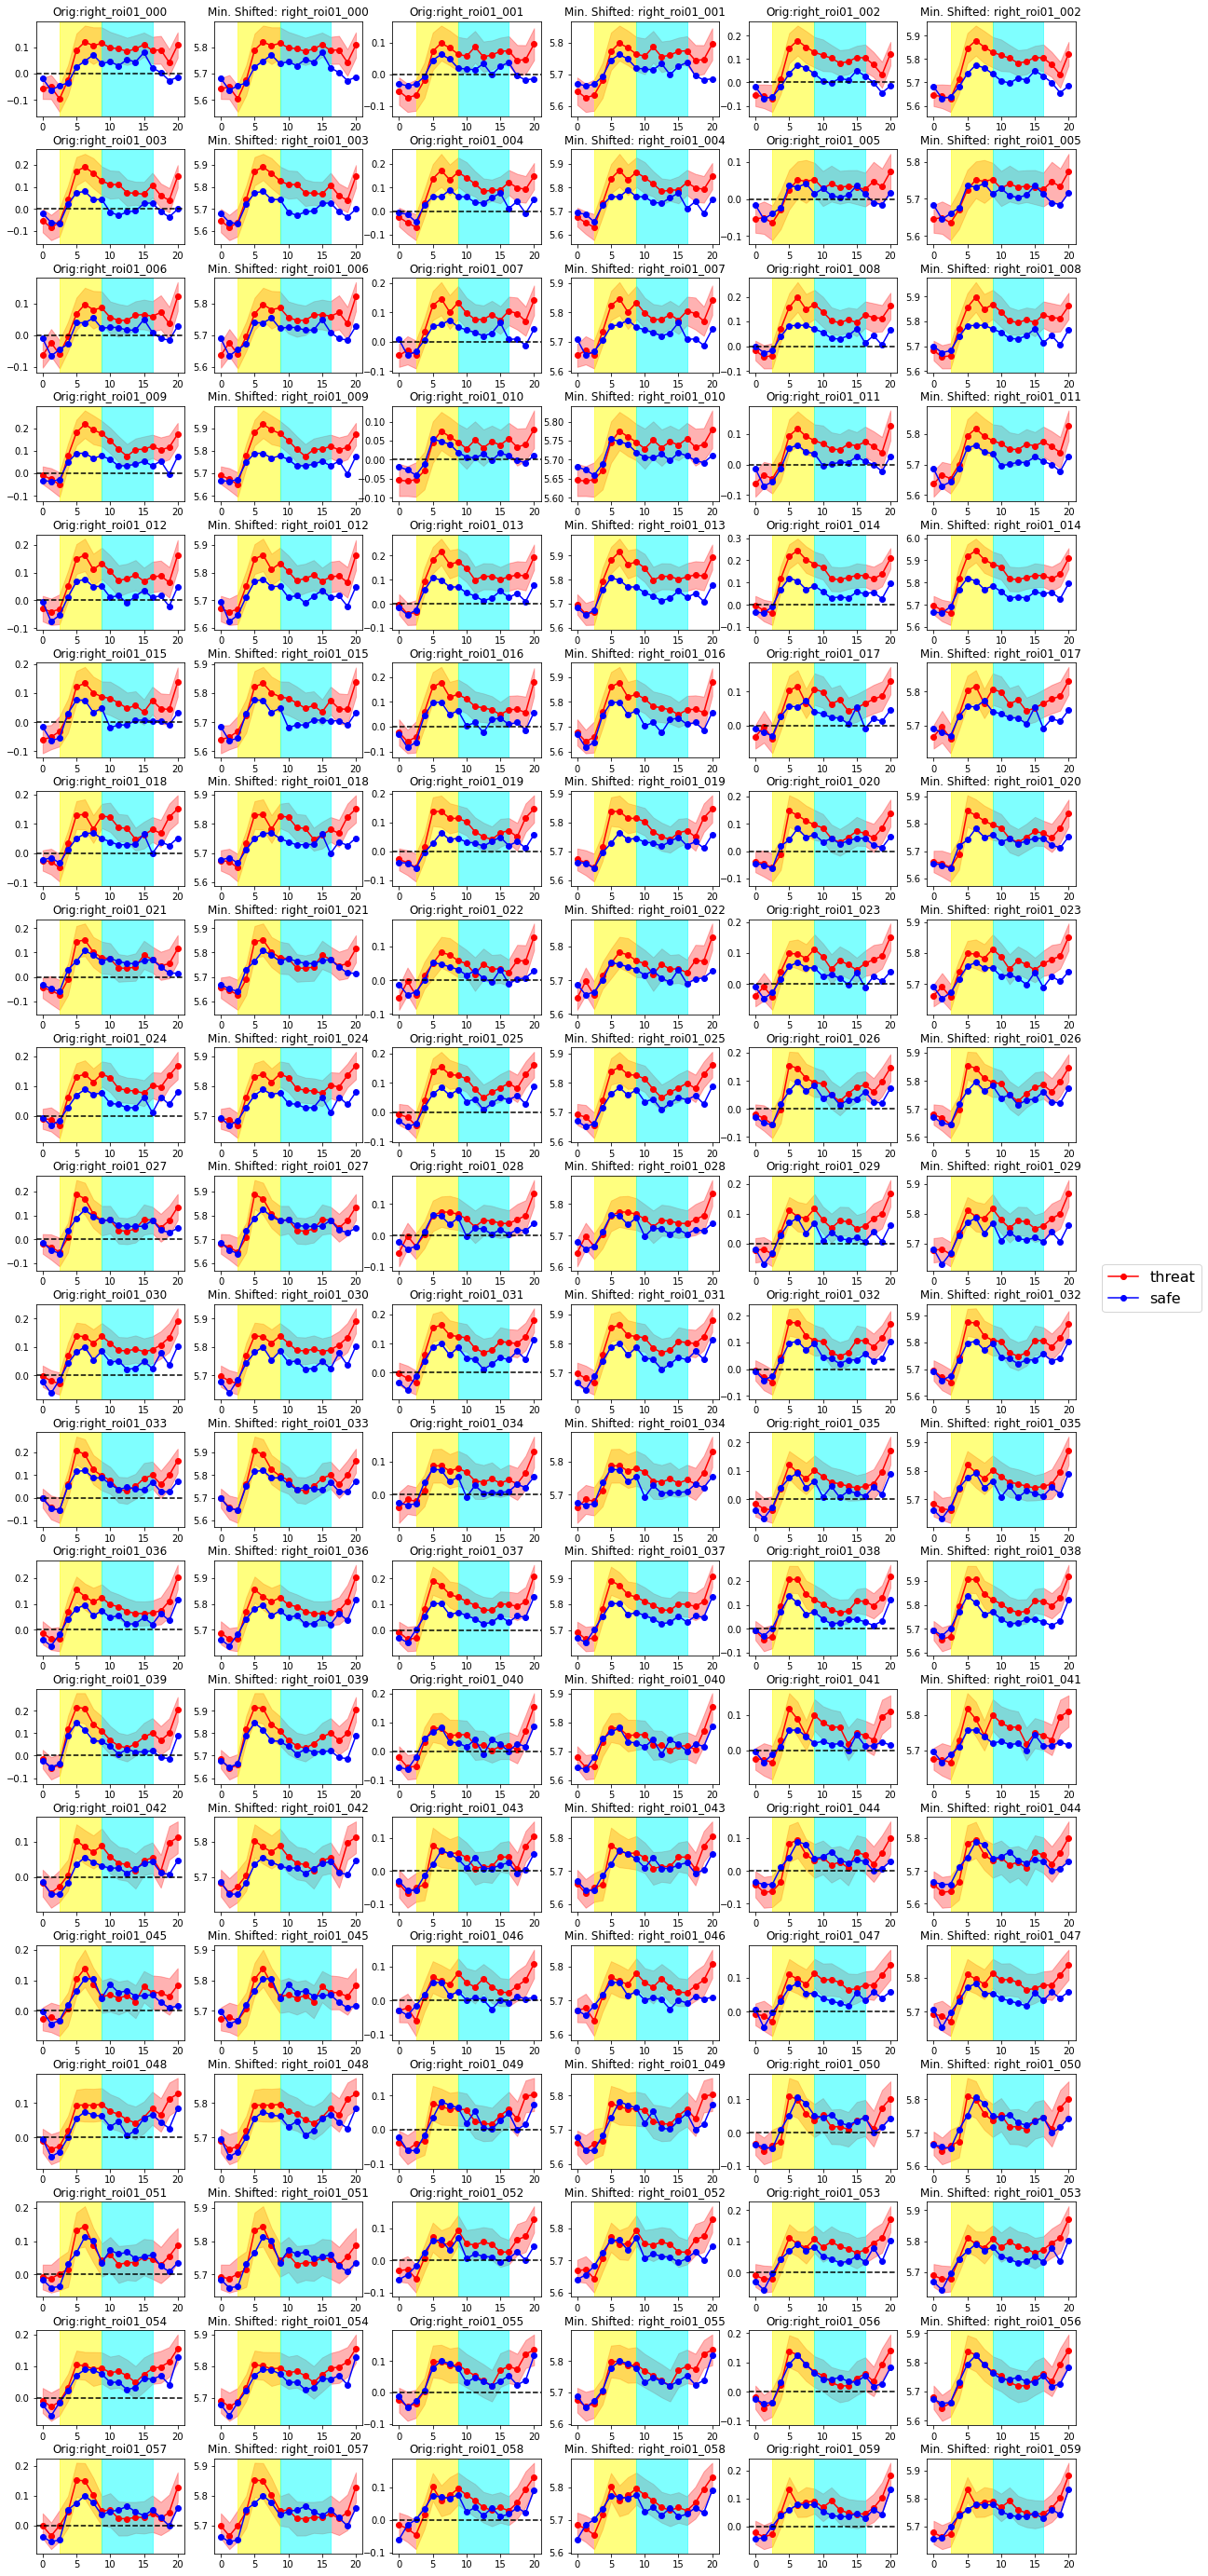

In [29]:
fig, axes = plt.subplots(nrows=20,ncols=6,figsize=(20,50),sharey=False)
axes = axes.flatten()
fig.subplots_adjust(wspace=0.2,hspace=0.35)
rois = df.VOX.unique()
t=np.arange(17)*1.25
for i, roi in enumerate(rois[:60]):
    ii = i*2
    
    orig_threat_df = orig_mean_df[(orig_mean_df['VOX']==roi) & (orig_mean_df['Type']=='threat')]
    orig_safe_df = orig_mean_df[(orig_mean_df['VOX']==roi) & (orig_mean_df['Type']=='safe')]
    axes[ii].plot(t,orig_threat_df['mean'],label='threat',color='red',marker='o')
    axes[ii].fill_between(t,orig_threat_df['lower_bound'],orig_threat_df['upper_bound'],alpha=0.3,color='red')
    axes[ii].plot(t,orig_safe_df['mean'],label='safe',color='blue',marker='o')
    axes[ii].axhline(y=0,linestyle='--',color='k')
    axes[ii].axvspan(xmin=2.5,xmax=8.75,color='yellow',alpha=0.5)
    axes[ii].axvspan(xmin=8.75,xmax=16.25,color='cyan',alpha=0.5)
    axes[ii].set_title('Orig:'+roi)
    
    
    offset_threat_df = offset_mean_df[(offset_mean_df['VOX']==roi) & (offset_mean_df['Type']=='threat')]
    offset_safe_df = offset_mean_df[(offset_mean_df['VOX']==roi) & (offset_mean_df['Type']=='safe')]
    axes[ii+1].plot(t,offset_threat_df['mean'],label='threat',color='red',marker='o')
    axes[ii+1].fill_between(t,offset_threat_df['lower_bound'],offset_threat_df['upper_bound'],alpha=0.3,color='red')
    axes[ii+1].plot(t,offset_safe_df['mean'],label='safe',color='blue',marker='o')
    axes[ii+1].axvspan(xmin=2.5,xmax=8.75,color='yellow',alpha=0.5)
    axes[ii+1].axvspan(xmin=8.75,xmax=16.25,color='cyan',alpha=0.5)
    axes[ii+1].set_title('Min. Shifted: '+roi)
    
_=fig.legend(axes[i].get_legend_handles_labels()[1],loc='center right',fontsize=16)

## STAI scores

In this section, STAI scores are standardized and added to the dataset

In [30]:
import re

STAI_path = '/data/bswift-1/Pessoa_Lab/MAX/June2020/dataset/behavioral/STAI_sums'
 
with open(STAI_path,'r') as file:
    names = re.split('\t| |\n',file.readline())

STAI=pd.read_csv(STAI_path,sep='\t',names=names[:3],skiprows=1)
STAI['Subj'] = STAI['subject'].apply(lambda ID: 'MAX{:03d}'.format(ID))
STAI.drop('subject',axis=1,inplace=True)
STAI = STAI[STAI.Subj.isin(df.Subj)]
STAI.set_index('Subj',inplace=True)
STAI.head()

,TRAIT,STATE
Subj,,
MAX101,27,22
MAX102,47,44
MAX103,33,32
MAX104,24,21
MAX105,56,28


In [31]:
# Standardize the covariates
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
STAI = pd.DataFrame(ss.fit_transform(STAI),columns=STAI.columns,index=STAI.index)
STAI.reset_index(inplace=True)
STAI.head()

,Subj,TRAIT,STATE
0,MAX101,-1.164152,-1.011495
1,MAX102,1.264414,1.539046
2,MAX103,-0.435582,0.147842
3,MAX104,-1.528437,-1.127429
4,MAX105,2.357268,-0.315893


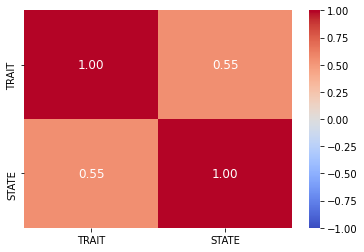

In [32]:
# Trait-State correlation 
_=sns.heatmap(STAI.corr(method='spearman'),vmin=-1,vmax=1,annot=True,fmt='.2f',cmap='coolwarm',annot_kws=dict(size=12))

## Aggregate Early/Late Periods 

This notebook aggregates responses from early (2.5-8.75s) and late periods (10-16.25s)

In [33]:
def phase(time):
    if (time >= 2.5 and time <= 8.75):
        return 'early'
    elif (time >= 10 and time <= 16.25):
        return 'late'
    else:
        return np.nan

In [34]:
# Add a phase column (early.late)
offset_df['Phase'] = offset_df['Time'].apply(phase)
offset_df.dropna(inplace=True)
offset_df.head()

,Subj,Type,Time,HEM,ROI,VOX,beta,var,Phase
2,MAX101,threat,2.50,right,right_roi01,right_roi01_000,5.5904,0.0469,early
3,MAX101,threat,3.75,right,right_roi01,right_roi01_000,5.5293,0.0468,early
4,MAX101,threat,5.00,right,right_roi01,right_roi01_000,5.7211,0.0469,early
5,MAX101,threat,6.25,right,right_roi01,right_roi01_000,5.8487,0.0472,early
6,MAX101,threat,7.50,right,right_roi01,right_roi01_000,6.0224,0.0471,early


In [38]:
agg_df = offset_df.groupby(['Subj','Type','HEM','ROI','VOX','Phase'])['beta'].sum()
agg_df = agg_df.to_frame(name='beta').reset_index()
agg_df = agg_df.merge(STAI)
agg_df.head()

,Subj,Type,HEM,ROI,VOX,Phase,beta,TRAIT,STATE
0,MAX101,safe,left,left_roi01,left_roi01_000,early,34.6336,-1.164152,-1.011495
1,MAX101,safe,left,left_roi01,left_roi01_000,late,35.0260,-1.164152,-1.011495
2,MAX101,safe,left,left_roi01,left_roi01_001,early,35.7197,-1.164152,-1.011495
3,MAX101,safe,left,left_roi01,left_roi01_001,late,35.9255,-1.164152,-1.011495
4,MAX101,safe,left,left_roi01,left_roi01_002,early,34.2874,-1.164152,-1.011495


In [39]:
agg_df['cond'] = agg_df['Type'].apply(lambda a: -0.5 if a=='safe' else 0.5)
agg_df.head()

,Subj,Type,HEM,ROI,VOX,Phase,beta,TRAIT,STATE,cond
0,MAX101,safe,left,left_roi01,left_roi01_000,early,34.6336,-1.164152,-1.011495,-0.5
1,MAX101,safe,left,left_roi01,left_roi01_000,late,35.0260,-1.164152,-1.011495,-0.5
2,MAX101,safe,left,left_roi01,left_roi01_001,early,35.7197,-1.164152,-1.011495,-0.5
3,MAX101,safe,left,left_roi01,left_roi01_001,late,35.9255,-1.164152,-1.011495,-0.5
4,MAX101,safe,left,left_roi01,left_roi01_002,early,34.2874,-1.164152,-1.011495,-0.5


In [40]:
if not exists('data/threat_v_safe_insula_min_shifted_agg.txt'):
    agg_df.to_csv('data/threat_v_safe_insula_min_shifted_agg.txt',sep=',',float_format='%.4f',index=False)